# **CMPE-257**

**Homework Week 9**

---

**Obtaining Adequate Gold Std and Sample Short Text to use sentiments, topics, POS and KG's to Analyze a Distribution of Acceptable (Gold Std) Text (NLU) and Comparing Samples with the Gold Standard**

---

```
Rishikesh Andhare
Jack Kalavadia
Rutvik Moradiya
Pramatha Nadig
```


## Dependencies

In [ ]:
!pip install bert-embedding
!pip install sentence-transformers
!pip install -U pandas-profiling
!pip install contractions
!pip install nltk
!pip install beautifulsoup4
!pip install pyLDAvis
!pip install lxml
!pip install pyvis==0.3.1
!pip install top2vec
!pip install top2vec
!pip install top2vec[sentence_encoders]
!pip install top2vec[sentence_transformers]
!pip install top2vec[indexing]
!pip install tensorflow-text

# When we run this cell we need to restart the runtime if we get a prompt otherwise it gives legacy-import error

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached bert_embedding-1.0.1-py3-none-any.whl (13 kB)
  Using cached typing-3.6.6-py3-none-any.whl (25 kB)
  Using cached numpy-1.14.6.zip (4.9 MB)
  Preparing metadata (setup.py) ... done
  Using cached mxnet-1.4.0-py2.py3-none-manylinux1_x86_64.whl (29.6 MB)
  Using cached gluonnlp-0.6.0-py3-none-any.whl
  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
  Running setup.py clean for numpy
  error: subprocess-exited-with-error
  
  × python setup.py clean did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed cleaning build dir for numpy
Failed to build numpy
ERROR: Could not buil

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import string
import wordcloud
import unicodedata
import contractions
import pickle
import requests
import spacy
import re
import pandas as pd
import nltk
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim
import gensim.corpora as corpora
import networkx as nx
import math
import torch
import random
import pickle

%matplotlib inline

from IPython.display import display, HTML
from typing import List
from lxml import etree
from bs4 import BeautifulSoup
from bs4.element import Comment
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from collections import defaultdict
from contractions import contractions_dict
from scipy import stats
from scipy import sparse
from wordcloud import WordCloud, STOPWORDS
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.porter import PorterStemmer
from sentence_transformers import SentenceTransformer, util
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from spacy import displacy
from pyvis.network import Network

from yellowbrick.text import PosTagVisualizer
from yellowbrick.text.postag import postag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Visualize the topics
pyLDAvis.enable_notebook()

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
scaler = MinMaxScaler()
std_scaler = StandardScaler()
stops = set(stopword_list)
stemmer = nltk.stem.SnowballStemmer('english')
wordlemmatizer = WordNetLemmatizer()
tokenizer = nltk.word_tokenize

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is

## Scraping Poems

In [ ]:
def scrape_poem_from_url1():
  url = 'https://iowapoetry.com/pushcart2022.htm'
  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')

  poems = []
  font = soup.find('font', face='fantasy')
  temp = []
  for child in font.children:
    if child.name == 'br':
      poem_map = {}
      poem_map['title'] = temp[1]
      poem_map['poet'] = temp[0]
      poem_map['poem'] = " ".join(temp[2:])
      poems.append(poem_map)
      temp = []
    else:
      val = child.text.strip()
      if val != '':
        val = val.replace('\xa0', '').replace('\r', ' ')
        temp_val = []
        for i in range(len(val) - 1):
          if val[i] == ' ' and val[i + 1] == ' ':
            continue
          else:
            temp_val.append(val[i])
        temp.append("".join(temp_val))
  poem_map = {}
  poem_map['title'] = temp[1]
  poem_map['poet'] = temp[0]
  poem_map['poem'] = " ".join(temp[2:])
  poems.append(poem_map)
  return poems

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def scrape_poem_from_url2():
  urls = [
      'https://roadrunner.lasierra.edu/departure/',
      'https://roadrunner.lasierra.edu/a-case-is-a-wave/',
      'https://roadrunner.lasierra.edu/astronaut/',
      'https://roadrunner.lasierra.edu/planting-seeds-in-a-desert/',
      'https://roadrunner.lasierra.edu/color-wheel/',
      'https://roadrunner.lasierra.edu/fronteras/'
  ]
  poems = []
  pattern = r'[0-9]'
  for url in urls:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    title = soup.find('div', class_='et_pb_text_1').text.strip()
    poet = soup.find('div', class_='et_pb_text_2').text.strip().replace('by', '')
    poem = soup.find('div', class_='et_pb_text_3').find('div', class_='et_pb_text_inner')
    temp = []
    for val in poem:
      temp.append(val.text.strip().replace('\xa0', '').replace('\r', ' '))
    poem_map = {}
    poem_map['title'] = title
    poem_map['poet'] = poet
    poem_map['poem'] = re.sub(pattern, '', " ".join(temp[:-3]))
    poems.append(poem_map)
  return poems

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pushcart_poems = [
    {
        'title': 'THE FATES',
        'poet': 'David Kirby',
        'poem': 'A child is born. It’s you! Family and friends stop by and then the whole neighborhood, it seems, including three women who sit in the corner and smile and nod at anyone who says hello, though mainly they keep to themselves, nibbling the cookies someone else has brought and sipping tea, and then the one nearestthe window takes a ball of yarn out of her purseand gives it to the one in the middle, who is knitting something—booties? a little cap?—as the third woman just sits there, a pair of scissors in her lap. Ten years later and you’re in school now, and even the lunchroom ladies are in a good mood as you step toward a table with an empty place, and an aide says Let me clean that for you and wipes the table down and pats you on the shoulder before she heads to the break room where her two friends wait. Your first job? You’re behind the counter in a department store, showing a watch to a woman who’s buying someone a present, and she pays you and puts the watch in her purse and waves to a woman at the perfume counter who hurries over and says Come on, we’re late, she’ll be waiting for us at the restaurant.It’s sunny yet cool the day you marry, and the venue costs more than your dad had in mind, but the ceremony goes off without a hitch, and the band is cranking the oldies so everyone will get out on the dance floor, and they’re all a little tipsy, and if your aunt’s friends are screeching so loudly as they do the Electric Slide that you can barely hear the music, it’s a wedding, right? Anything goes. In New York a man whose manuscript has been rejected twenty times is walking down Madison Avenue when he is bumped off the sidewalk by a gaggle of women who don’t seem to notice him, and a car slams on its brakes, and the driver is a classmate he hasn’t seen for years who has recently become an editor with a trade press, and the man gets in the car, and by the end of the month he has a book deal, and after twenty years and dozens of books in print he thinks, If I hadn’t stepped out into the street, I’d be in the dry cleaning business now.In Africa a man emerges from the jungle, his bag dripping blood: it was a good day, and now his bag bulges with bats, rats, chimps, even a snake or two. Others have died, like the hunters who had cooked and eaten the carcass of a gorilla they’d found in the jungle. But who would do that? Bats are healthy: look at them soar from tree to tree! At the market, the man’s wives spread the bushmeaton a cloth and begin to bargain. A ferry sinks off the coast of South Korea, and among the dead are seven crew members, including three women who gave their life jackets to passengers. Your own children are born. They, too, go to school, to work, get married. You have a long life, a good one. You weren’t the kid who got picked up by a guy who was driving a stolen car and sent to juvie for being an accessory. You weren’t the one who tried to break up the fight and got knocked down on the sidewalk and hit your head and never stood up again. You weren’t those people. Your accidents were good accidents, and when they weren’t, you learned from them. A nurse comes in and takes a tube out of your arm as another adjusts your ventilator and a third says the doctor will be in soon, and the nurses’ names are Clotho, who spins the web of life, and Lachesis, who measures it, and Atropos, who cuts that thread when your life is over, and as they make a fuss, you think how poetry entered you and became like a mistress in her own home, one you had not summoned but who entered your body of her own accord, this force into which everything—work, the sound of tires on pavement, home, birds, rocks, love, the whole world—entered easily and made itself comfortable, stanzas rising and falling, one after another, in a way that was always surefooted, always a surprise. The world rushed in at the speed of a comet, everything shouting, “Take me!” and “No, no—take me!” and all this without your ever having written a single line of poetry in your entire life, though along the way you learned to think like a poet, to take this over that, to begin here and end there and then the other way around until at last you could see your life as it really is and make sense of it, or at least as much sense as one can, and now you are opening your eyes for the first time, and now you are eating, and now you are walking from one side of the room to the other, and now you are a little girl on her bicycle, flying out into this sunlit world.'
    },
    {
        'title': 'HAIKU',
        'poet': 'Joshua Eric Williams',
        'poem': 'silent after the shooting stars'
    },
    {
        'title': 'I TELL MY SON TO COVER HIMSELF IN SOMEONE ELSE’S BLOOD',
        'poet': 'Rachel Mallalieu',
        'poem': 'Last night, I told my son that if he sees a shooter coming, he needs to hide in a file cabinet or underneath a covered table. If he’s in the bathroom, he should stand on the toilet and lock the stall door. If there’s nowhere to go, I asked him to paint himself with someone else’s blood and play dead. Give him a break my husband murmured. Let him relax a bit. Simon needed extra prayers at bedtime. Say my name out loud. Tell God to keep me safe, or at least don’t let him come while I’m in art class. During shooter drills, my teacher forgot to lock the door and the window is too big to cover with paper. I smoothed the circles under his eyes while I begged God to keep him here, with me. Today, the forest is a cathedral and cedar trees waft incense. The blossoms are a riotous crowd —tulip poplars, mountain laurel, dogwoods and wisteria. The “About Me” poster outside Simon’s fourth grade classroom says he loves our dog Theo and tacos. His favorite color is green. He wants to be a doctor. The trees hush the sirens and only the flowers hear the whispered coda to my prayer. If he comes, God, and Simon can’t hide, please please God, let me be there too. The blooms, mute gods, bend their faces toward my cries and promise nothing.'
    },
    {
        'title': 'SOPRANO FROM THE JUNIOR CHOIR AT THE PROTEST',
        'poet': 'Shawn R. Jones',
        'poem': 'Her larynx is raw from chanting. Every diphthong and syllable aflame. Each vowel broken. She cannot sing, We Shall Overcome. That was her grandmother’s song. And she is not her grandmother. So forgive her for wanting the police precinct destroyed. Forgive her for cheering as patrol cars scream between flames. Forgive her for looting the Smoke Shop in the alley on James Street. Forgive her for listening to Floyd cry, “Momma” four hundred times on her cell phone as she fills a bong with kerosene. Forgive her as she sticks a rag in its petite mouth and turns the soft pink cloth into wick. Forgive her. Forgive her as she leans back, steps forward, shifts her full body weight, twists her torso, drives her elbow forward, and releases the bong— a torched bird with variegated wings.'
    }
]
pushcart_poems += scrape_poem_from_url1() + scrape_poem_from_url2()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pushcart_poems

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'title': 'THE FATES',
  'poet': 'David Kirby',
  'poem': 'A child is born. It’s you! Family and friends stop by and then the whole neighborhood, it seems, including three women who sit in the corner and smile and nod at anyone who says hello, though mainly they keep to themselves, nibbling the cookies someone else has brought and sipping tea, and then the one nearestthe window takes a ball of yarn out of her purseand gives it to the one in the middle, who is knitting something—booties? a little cap?—as the third woman just sits there, a pair of scissors in her lap. Ten years later and you’re in school now, and even the lunchroom ladies are in a good mood as you step toward a table with an empty place, and an aide says Let me clean that for you and wipes the table down and pats you on the shoulder before she heads to the break room where her two friends wait. Your first job? You’re behind the counter in a department store, showing a watch to a woman who’s buying someone a present, and

In [ ]:
def beautify_txt(text):
    final_data = (((text).replace(u'\xa0', u' ')).replace(r'\r',u'\n').replace("©  on Apr 22 2023 09:49 PM PST   ", ""))
    return final_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
non_pushcart_url = [
    'https://allpoetry.com/poem/17127212-Lack-of-a-Daisy-by-Au.tumnn',
    'https://allpoetry.com/poem/17127160-Travellers-by-Betty15',
    'https://allpoetry.com/poem/17127095-A-Butterfly-by-Bella-UwU-2002',
    'https://allpoetry.com/poem/17142541-Black-Beauty-by-Anthony-Acquah',
    'https://allpoetry.com/poem/17142539-Have-a-safe-flight--by-Sharan-Aansu',
    'https://allpoetry.com/poem/17142538-You-Could-Hear-a-Cat-Drop-by-PinkFaerie5',
    'https://allpoetry.com/poem/17142537-dancing-with-mahi-mahis-by-Mermaid',
    'https://allpoetry.com/poem/17142542-Dismayed--by-Peewee-Cuson',
    'https://allpoetry.com/poem/17142535-A-Delgithfully-Prance-y--Dance-y--Happy-Day--by-PinkFaerie5',
    'https://allpoetry.com/poem/17142534-Fool-Bodied-Forth-by-Doc-jrs-III',
    'https://allpoetry.com/poem/17142533-By-the-Pond-by-Gilbert-Williams',
    'https://allpoetry.com/poem/17142532-The-November-Expedition--by-EsteEsEsteban',
    'https://allpoetry.com/poem/17142531-Hum-of-the-million-things-by-Witchess-adult',
    'https://allpoetry.com/poem/17142530-Someone-knows-by-DreamStars'
    ]
non_pushcart_poems = []
for url in non_pushcart_url:
    print(url)
    response = requests.get(url)
    soup = BeautifulSoup(response.content,'html.parser')

    poem_content = soup.find_all('div', class_="poem_body")[0]
    poem = []
    for child in poem_content:
      poem.append(child.text.strip())
    poem_title = soup.find_all('h1')[0].text
    non_pushcart_poems.append(
        {'title':poem_title,
         'poem':" ".join(poem[:len(poem) - 1])}
        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


https://allpoetry.com/poem/17127212-Lack-of-a-Daisy-by-Au.tumnn
https://allpoetry.com/poem/17127160-Travellers-by-Betty15
https://allpoetry.com/poem/17127095-A-Butterfly-by-Bella-UwU-2002
https://allpoetry.com/poem/17142541-Black-Beauty-by-Anthony-Acquah
https://allpoetry.com/poem/17142539-Have-a-safe-flight--by-Sharan-Aansu
https://allpoetry.com/poem/17142538-You-Could-Hear-a-Cat-Drop-by-PinkFaerie5
https://allpoetry.com/poem/17142537-dancing-with-mahi-mahis-by-Mermaid
https://allpoetry.com/poem/17142542-Dismayed--by-Peewee-Cuson
https://allpoetry.com/poem/17142535-A-Delgithfully-Prance-y--Dance-y--Happy-Day--by-PinkFaerie5
https://allpoetry.com/poem/17142534-Fool-Bodied-Forth-by-Doc-jrs-III
https://allpoetry.com/poem/17142533-By-the-Pond-by-Gilbert-Williams
https://allpoetry.com/poem/17142532-The-November-Expedition--by-EsteEsEsteban
https://allpoetry.com/poem/17142531-Hum-of-the-million-things-by-Witchess-adult
https://allpoetry.com/poem/17142530-Someone-knows-by-DreamStars


In [ ]:
non_pushcart_poems

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'title': 'Lack of a Daisy',
  'poem': ' There was a daisy\nDancing on a floating island in the cosmic night\nHer petals smiling at you\nLooking up you see that bright light\nBillions of lives floating in the sky\n\nThey’re all gone now\nBurnt grass and ashes below your feet\nSparks of ember singing in the air\nThe watch on your wrist turned gray\nThat too, turned into ashes\n\nYou remember laughter\nSweet warm nectar\nYou feel it in your hands and\nsplash it on your face\nThat too, turned into ashes\n\nYour hand holds a daisy\nGlowing white and yellow\nIt whispers to you and\nmelts out of your hand\nThat too, turned into ashes\n\nYou look in the water\nA little pond with your name\nSwirling memories, distant sounds\nYour face reflecting off the water\nThat too, turned into ashes'},
 {'title': 'Travellers',
  'poem': ' If someone dies\nthe air is often full of sighs\nand tearful sad goodbyes\nif young\nwe mourn\nthe shortened span of life\nsince they were born\nif old\nwe bow our head

In [ ]:
def cleanPoemText(text):

    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'re", " are", text)

    if embedding is not 'BERT':
        text = re.sub(r"[0-9]+", ' ', text)
        text = re.sub(r"-", ' ', text)


    text = text.strip().lower()

    if embedding is 'WORD2VEC_NO_STOP':
        # Removal of Stop words
        default_stop_words = set(stopwords.words('english'))
        default_stop_words.difference_update({'no', 'not', 'nor', 'too', 'any'})
        stop_words = default_stop_words.union({"'m", "n't", "'d", "'re", "'s",
                                               'would','must',"'ve","'ll",'may'})

        word_list = word_tokenize(text)
        filtered_list = [w for w in word_list if not w in stop_words]
        text = ' '.join(filtered_list)

    if embedding is not 'BERT':
        # Removal of other contractions
        text = re.sub(r"'", ' ', text)

    # Replace punctuations with space
    if embedding is 'BERT': # save ! ? . for end of the sentence detection [,/():;']
        filters='"#$%&*+<=>@[\\]^_`{|}~\t\n'
        text = re.sub(r'\!+', '!', text)
        text = re.sub(r'\?+', '?', text)
    else:
        filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((i, " ") for i in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    if embedding is 'BERT':
        text = re.sub(r'\( *\)', ' ', text)

    if embedding is not 'BERT':
        text = ' '.join([w for w in text.split() if len(w)>1])

    # Replace multiple space with one space
    text = re.sub(' +', ' ', text)

    text = ''.join(text)

    return text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:47: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:44

## POS

In [ ]:
def pos_tagging(Poem):
  tokenized_text = word_tokenize(Poem)
  pos_tags= nltk.pos_tag(tokenized_text)
  return pos_tags

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pushcart_pos = []
for val in (pushcart_poems):
  i = {}
  i['POS'] = pos_tagging(val['poem'])
  i['Verb']= ([word for (word, pos) in i['POS'] if (pos.startswith('VB'))])
  i['Adjective']= ([word for (word, pos) in i['POS'] if (pos.startswith('J'))])
  i['Adverbs']= ([word for (word, pos) in i['POS'] if (pos.startswith('RB'))])
  i['Nouns']= ([word for (word, pos) in i['POS'] if (pos.startswith('NN'))])
  pushcart_pos.append(i)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pushcart_pos[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'POS': [('A', 'DT'),
  ('child', 'NN'),
  ('is', 'VBZ'),
  ('born', 'VBN'),
  ('.', '.'),
  ('It', 'PRP'),
  ('’', 'VBZ'),
  ('s', 'NN'),
  ('you', 'PRP'),
  ('!', '.'),
  ('Family', 'RB'),
  ('and', 'CC'),
  ('friends', 'NNS'),
  ('stop', 'VBN'),
  ('by', 'IN'),
  ('and', 'CC'),
  ('then', 'RB'),
  ('the', 'DT'),
  ('whole', 'JJ'),
  ('neighborhood', 'NN'),
  (',', ','),
  ('it', 'PRP'),
  ('seems', 'VBZ'),
  (',', ','),
  ('including', 'VBG'),
  ('three', 'CD'),
  ('women', 'NNS'),
  ('who', 'WP'),
  ('sit', 'VBP'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('corner', 'NN'),
  ('and', 'CC'),
  ('smile', 'NN'),
  ('and', 'CC'),
  ('nod', 'NN'),
  ('at', 'IN'),
  ('anyone', 'NN'),
  ('who', 'WP'),
  ('says', 'VBZ'),
  ('hello', 'NN'),
  (',', ','),
  ('though', 'IN'),
  ('mainly', 'RB'),
  ('they', 'PRP'),
  ('keep', 'VBP'),
  ('to', 'TO'),
  ('themselves', 'PRP'),
  (',', ','),
  ('nibbling', 'VBG'),
  ('the', 'DT'),
  ('cookies', 'NNS'),
  ('someone', 'NN'),
  ('else', 'RB'),
  ('has', 'VB

In [ ]:
non_pushcart_pos = []
for val in (non_pushcart_poems):
  i = {}
  i['POS'] = pos_tagging(val['poem'])
  i['Verb']= ([word for (word, pos) in i['POS'] if (pos.startswith('VB'))])
  i['Adjective']= ([word for (word, pos) in i['POS'] if (pos.startswith('J'))])
  i['Adverbs']= ([word for (word, pos) in i['POS'] if (pos.startswith('RB'))])
  i['Nouns']= ([word for (word, pos) in i['POS'] if (pos.startswith('NN'))])
  non_pushcart_pos.append(i)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
non_pushcart_pos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'POS': [('There', 'EX'),
   ('was', 'VBD'),
   ('a', 'DT'),
   ('daisy', 'JJ'),
   ('Dancing', 'NNP'),
   ('on', 'IN'),
   ('a', 'DT'),
   ('floating', 'VBG'),
   ('island', 'NN'),
   ('in', 'IN'),
   ('the', 'DT'),
   ('cosmic', 'JJ'),
   ('night', 'NN'),
   ('Her', 'PRP$'),
   ('petals', 'NNS'),
   ('smiling', 'VBG'),
   ('at', 'IN'),
   ('you', 'PRP'),
   ('Looking', 'VBG'),
   ('up', 'RP'),
   ('you', 'PRP'),
   ('see', 'VBP'),
   ('that', 'IN'),
   ('bright', 'JJ'),
   ('light', 'JJ'),
   ('Billions', 'NNS'),
   ('of', 'IN'),
   ('lives', 'NNS'),
   ('floating', 'VBG'),
   ('in', 'IN'),
   ('the', 'DT'),
   ('sky', 'NN'),
   ('They', 'PRP'),
   ('’', 'VBP'),
   ('re', 'VB'),
   ('all', 'DT'),
   ('gone', 'VBN'),
   ('now', 'RB'),
   ('Burnt', 'NNP'),
   ('grass', 'NN'),
   ('and', 'CC'),
   ('ashes', 'NNS'),
   ('below', 'IN'),
   ('your', 'PRP$'),
   ('feet', 'NNS'),
   ('Sparks', 'NNPS'),
   ('of', 'IN'),
   ('ember', 'NN'),
   ('singing', 'NN'),
   ('in', 'IN'),
   ('the', 'D

In [ ]:
pushcart_poems_df = pd.DataFrame.from_dict(pushcart_pos)
non_pushcart_poems_df = pd.DataFrame.from_dict(non_pushcart_pos)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
non_pushcart_poems_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


POS  \
0   [(There, EX), (was, VBD), (a, DT), (daisy, JJ)...   
1   [(If, IN), (someone, NN), (dies, VBZ), (the, D...   
2   [(I, PRP), (saw, VBD), (a, DT), (butterfly, NN...   
3   [(Luscious, JJ), (Lips, NNP), (Curvaceous, NNP...   
4   [(Parting, VBG), (Will, MD), (be, VB), (diffic...   
5   [(So, IN), (quiet, JJ), (now, RB), (you, PRP),...   
6   [(silver, NN), (sliver, NN), (gills, NNS), (sh...   
7   [(On, IN), (given, VBN), (days, NNS), (I, PRP)...   
8   [(It, PRP), (was, VBD), (a, DT), (delightfully...   
9   [(or, CC), (Such, JJ), (Stuff, NNP), (As, IN),...   
10  [(I, PRP), (’, VBP), (d, JJ), (see, VBP), (the...   
11  [(I, PRP), (live, VBP), (,, ,), (I, PRP), (lea...   
12  [(cold, JJ), (lake, NN), (shivers, NNS), (with...   
13  [(Sunlight, NNP), (drips, NNS), (on, IN), (mou...   

                                                 Verb  \
0   [was, floating, smiling, Looking, see, floatin...   
1   [dies, is, mourn, were, born, bow, wish, are, ...   
2   [saw, came, warning, went, dreamt, mutating, s...   
3   [Enticing, walk, were, be, speak, is, Reproduc...   
4   [Parting, be, carry, ’, weeping, Wiping, lava,...   
5                         [hear, land, are, twisting]   
6                               [shimmer, fulfilling]   
7   [given, don, understand, are, need, have, thou...   
8   [was, did, frolicked, frisked, hey, do, know, ...   
9   [Made, sole, sinking, possessed, speak, iambs,...   
10  [’, see, were, falling, ’, shuffling, fallen, ...   
11  [live, learn, decimate, rend, did, deserve, ch...   
12                                                 []   
13  [memorized, begins, fly, knows, go, see, falls...   

                                            Adjective  \
0   [daisy, cosmic, bright, light, gray, laughter,...   
1   [full, tearful, sad, young, shortened, old, pe...   
2   [unpaused, scent, new, fly, high, Many, sticky...   
3   [Luscious, African, Your, melodious, such, upr...   
4     [difficult, ll, resist, ll, ll, constant, safe]   
5             [quiet, easy, gentle, bus, stop, sweet]   
6              [thalassic, orcas, liquid, crustacean]   
7   [most, luckier, long, tried, short, thin, few,...   
8               [prance-y, dance-y, happy, exuberant]   
9   [Such, booze, sherris, divine, such, coy, come...   
10  [d, old, d, grey-coated, stiff-legged, lengthe...   
11  [optimistic, grave, dark, last, worse, cold, l...   
12                                [cold, sole, sound]   
13               [same, unearthly, high, s, far-away]   

                                              Adverbs  \
0                           [now, too, too, too, too]   
1                                     [often, always]   
2                         [then, now, here, n't, too]   
3                                [elegantly, so, not]   
4             [not, Very, close, now, too, too, back]   
5                          [now, Not, as, always, so]   
6                                                  []   
7   [n't, never, i, even, never, then, too, most, ...   
8                   [delightfully, simply, not, else]   
9                     [too, ne'er, so, so, not, once]   
10  [close, only, only, then, together, ve, long, ...   
11                         [so, headfirst, n't, only]   
12                                                 []   
13                                                 []   

                                                Nouns  
0   [Dancing, island, night, petals, Billions, liv...  
1   [someone, air, sighs, goodbyes, span, life, he...  
2   [butterfly, yesterday, morning, space, cocoon,...  
3   [Lips, Curvaceous, Hips, A, body, Sculptured, ...  
4   [Bitterly, My, mind, intellect, Molten, hub, m...  
5   [cat, drop, feet, plunk, window, Natural, cont...  
6   [silver, sliver, gills, aquatics, churn, bubbl...  
7   [days, mask, man, mingle, people, perspective,...  
8   [day, baby, goats, joyful, sashay, hey, hey, h...  
9   [Stuff, John-a-dreams, Is, Reason, sobers, art...  
10  [leave

In [ ]:
pushcart_pos[0]['POS']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('A', 'DT'),
 ('child', 'NN'),
 ('is', 'VBZ'),
 ('born', 'VBN'),
 ('.', '.'),
 ('It', 'PRP'),
 ('’', 'VBZ'),
 ('s', 'NN'),
 ('you', 'PRP'),
 ('!', '.'),
 ('Family', 'RB'),
 ('and', 'CC'),
 ('friends', 'NNS'),
 ('stop', 'VBN'),
 ('by', 'IN'),
 ('and', 'CC'),
 ('then', 'RB'),
 ('the', 'DT'),
 ('whole', 'JJ'),
 ('neighborhood', 'NN'),
 (',', ','),
 ('it', 'PRP'),
 ('seems', 'VBZ'),
 (',', ','),
 ('including', 'VBG'),
 ('three', 'CD'),
 ('women', 'NNS'),
 ('who', 'WP'),
 ('sit', 'VBP'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('corner', 'NN'),
 ('and', 'CC'),
 ('smile', 'NN'),
 ('and', 'CC'),
 ('nod', 'NN'),
 ('at', 'IN'),
 ('anyone', 'NN'),
 ('who', 'WP'),
 ('says', 'VBZ'),
 ('hello', 'NN'),
 (',', ','),
 ('though', 'IN'),
 ('mainly', 'RB'),
 ('they', 'PRP'),
 ('keep', 'VBP'),
 ('to', 'TO'),
 ('themselves', 'PRP'),
 (',', ','),
 ('nibbling', 'VBG'),
 ('the', 'DT'),
 ('cookies', 'NNS'),
 ('someone', 'NN'),
 ('else', 'RB'),
 ('has', 'VBZ'),
 ('brought', 'VBN'),
 ('and', 'CC'),
 ('sipping', 'VBG'),

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


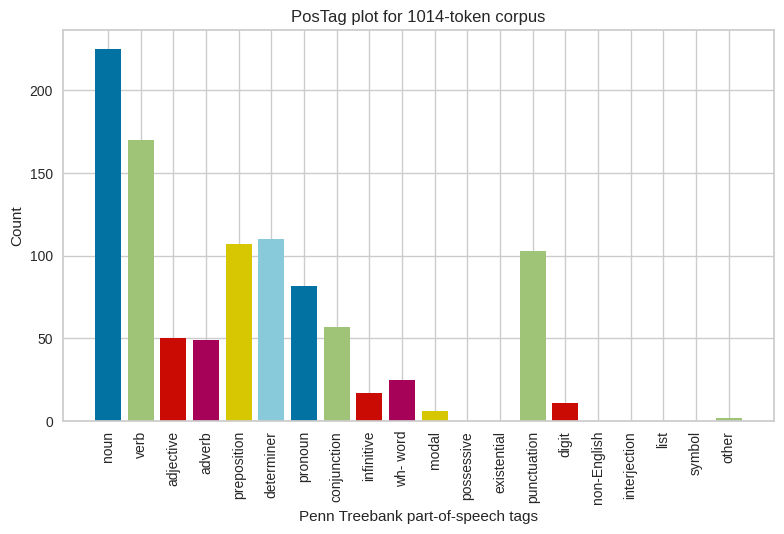

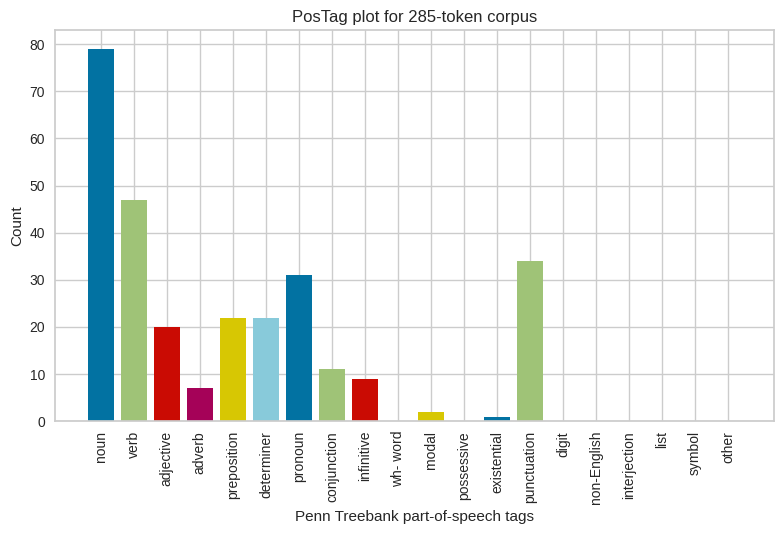

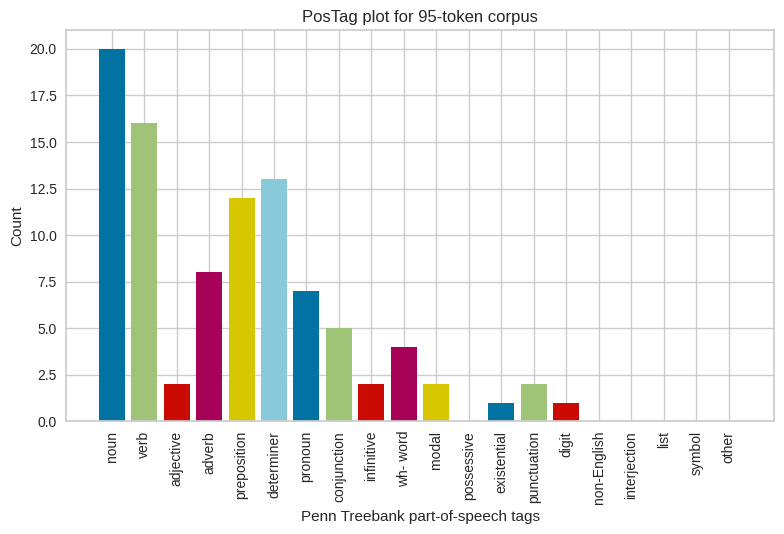

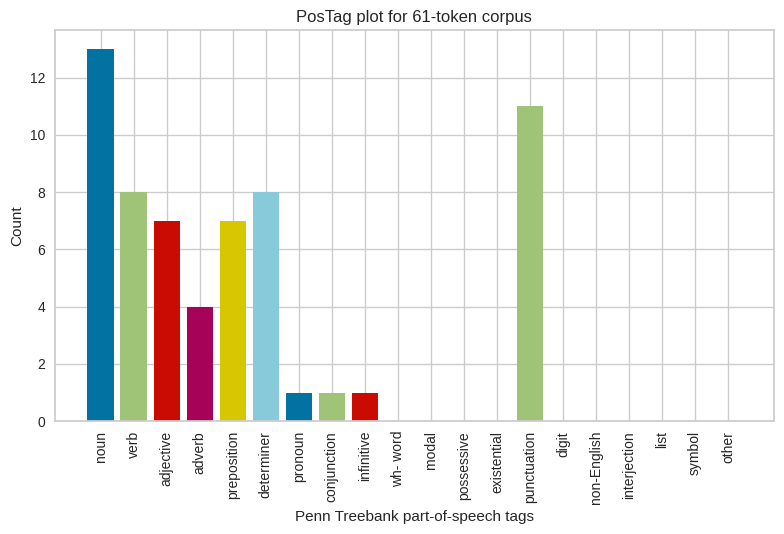

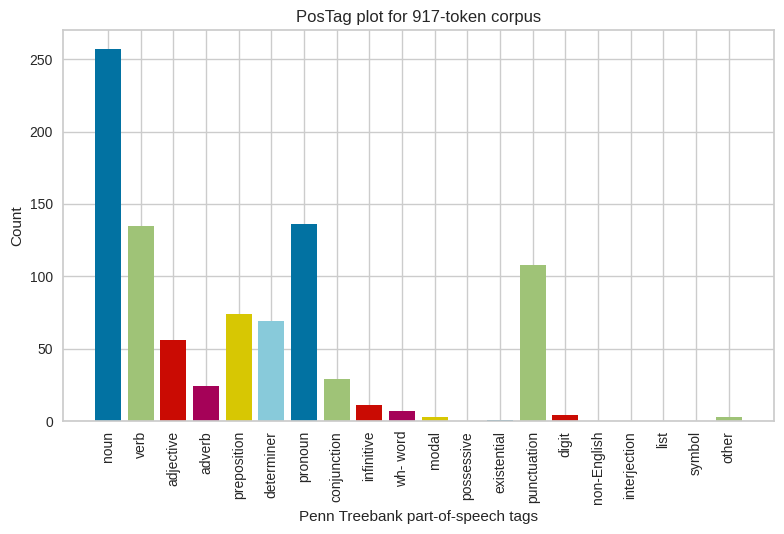

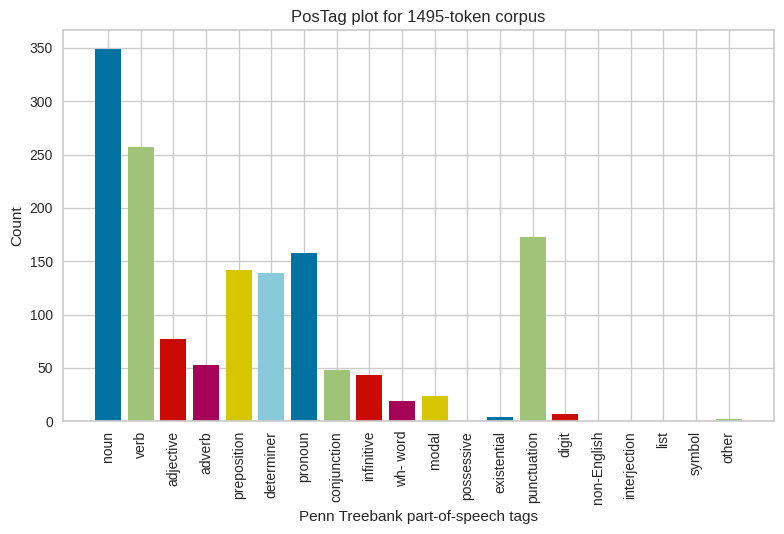

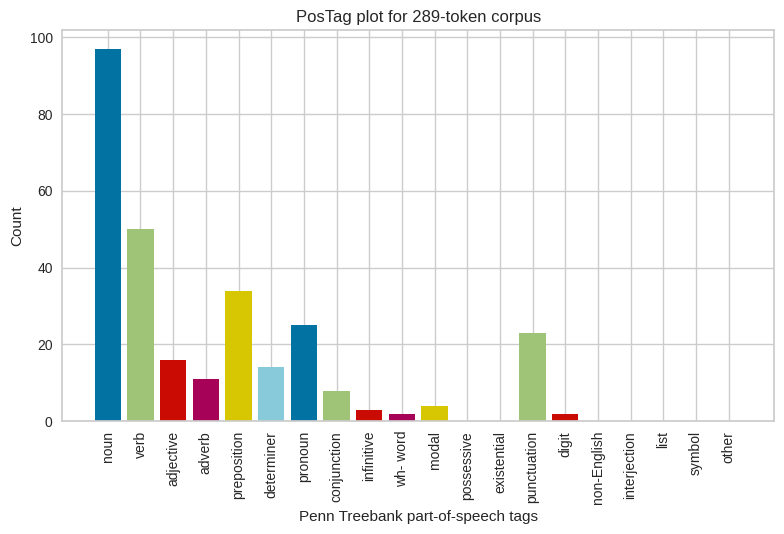

In [ ]:
for val in pushcart_poems_df['POS']:
  postag([[val]])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


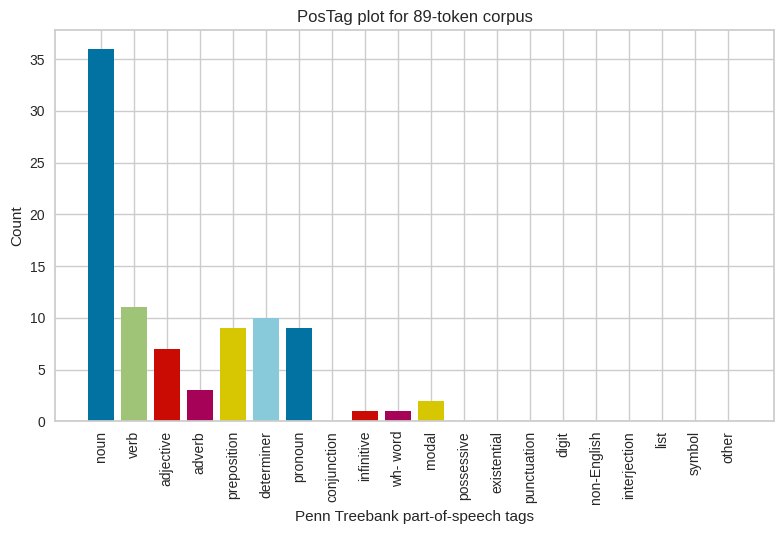

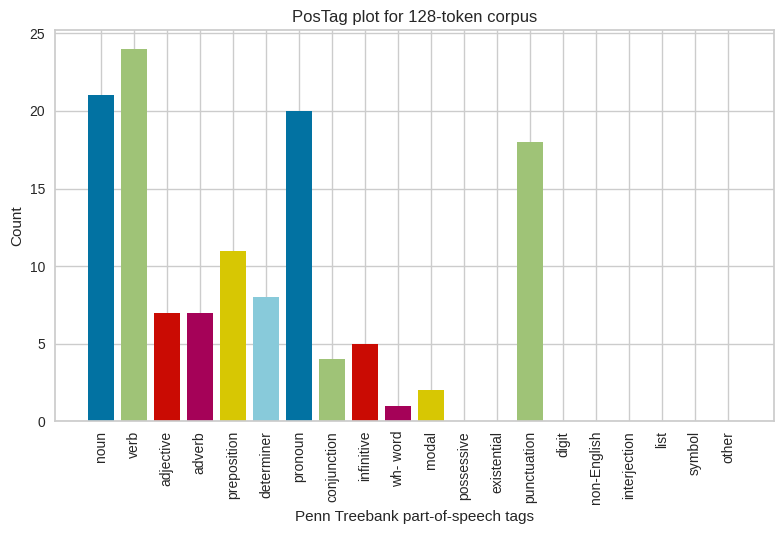

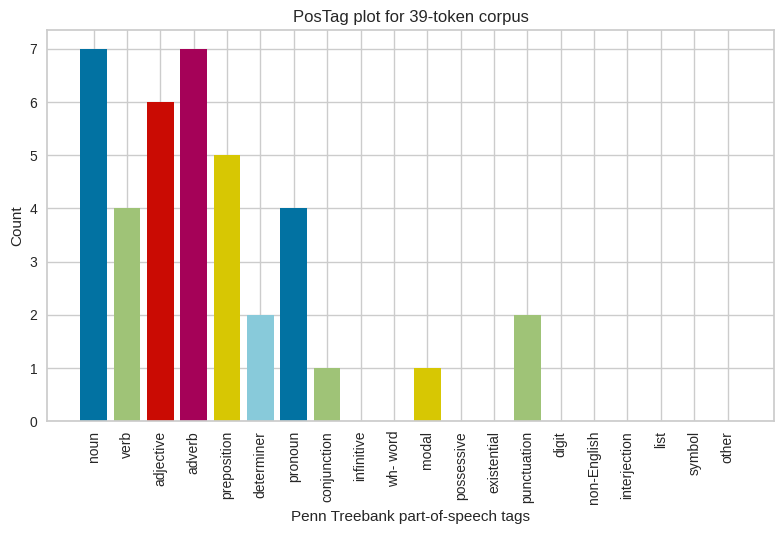

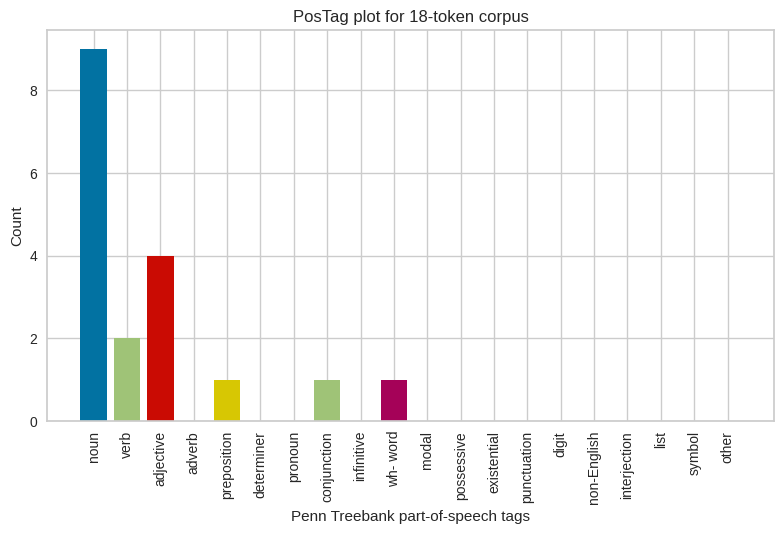

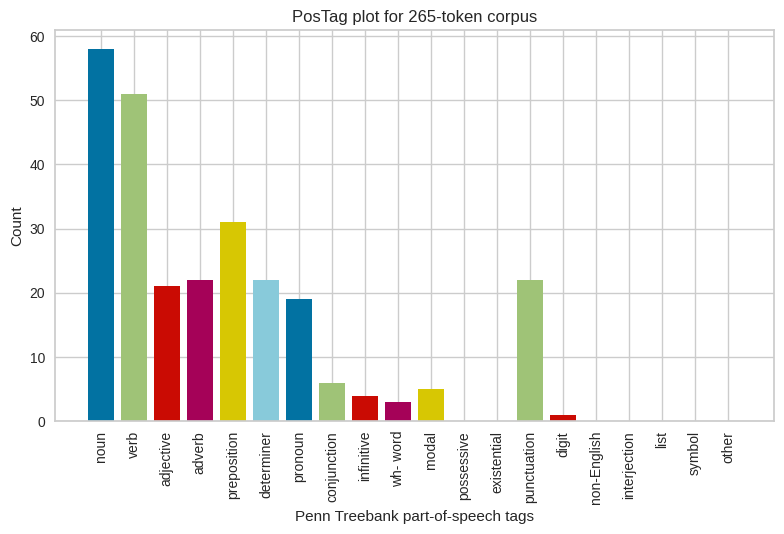

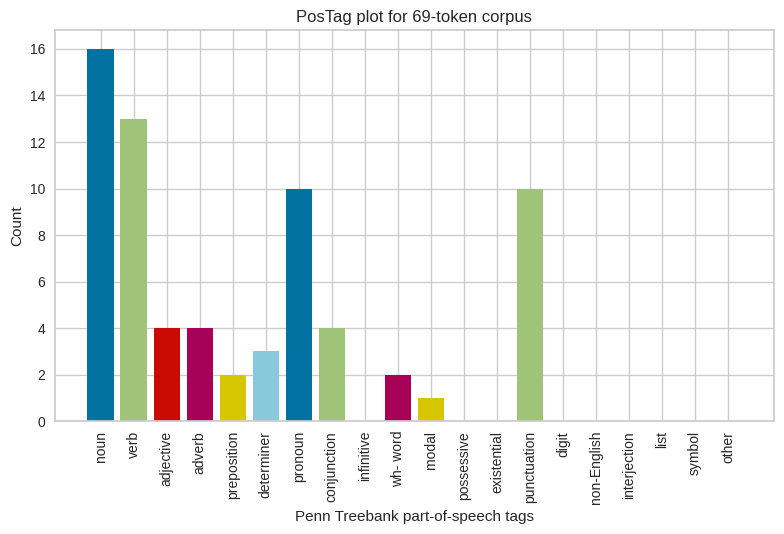

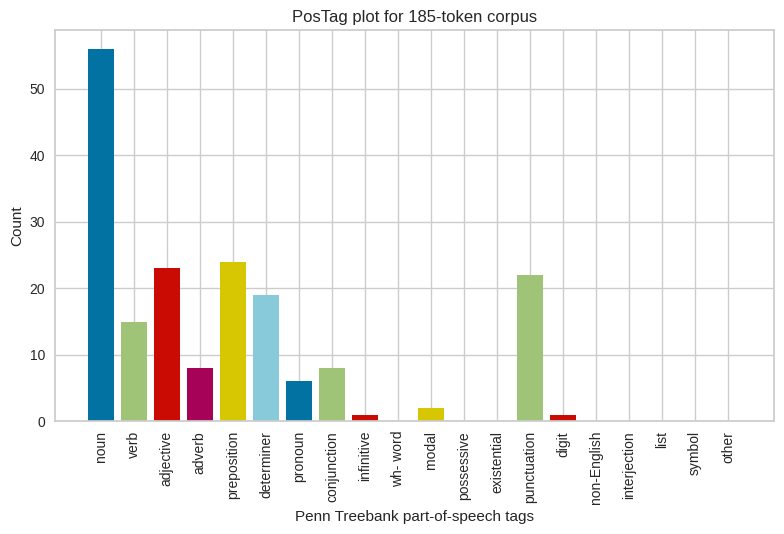

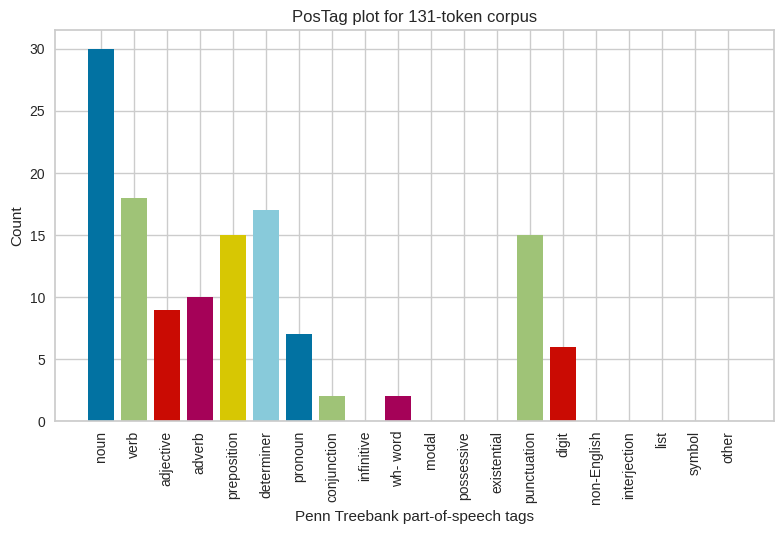

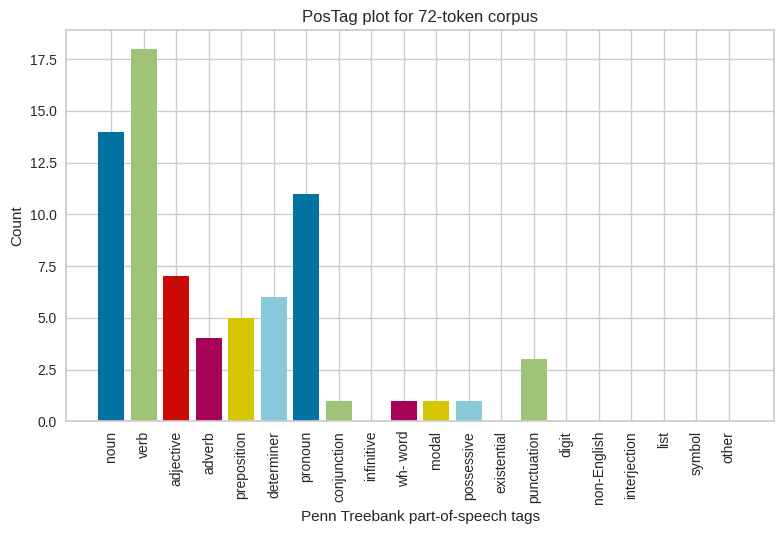

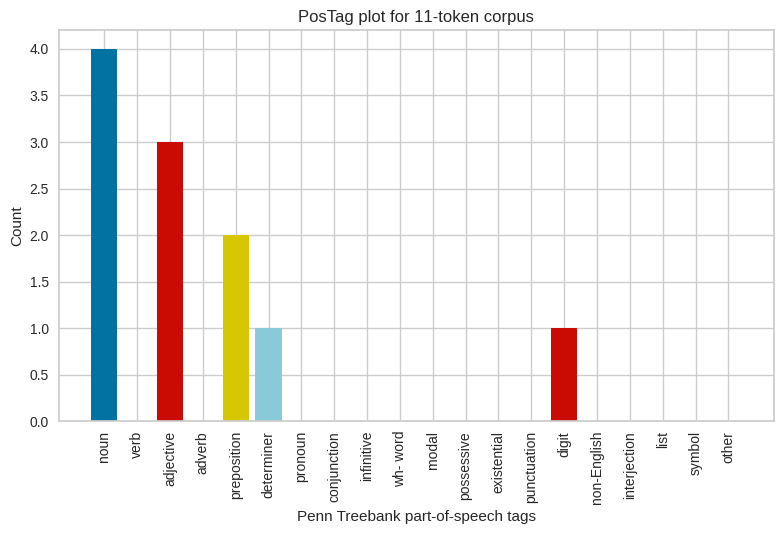

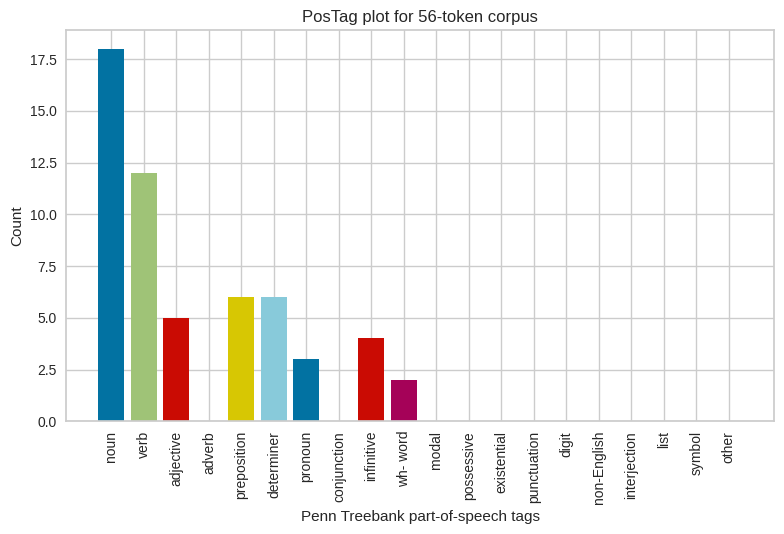

In [ ]:
for val in non_pushcart_poems_df['POS']:
  postag([[val]])

## Topic Analysis

In [ ]:
def choherence_perplexity_calculator(poem_list):
  def sent_to_words(sentences):
      for sentence in sentences:
          yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

  data_words = list(sent_to_words(poem_list))

  print(data_words[:1])
  # Build the bigram and trigram models
  bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
  trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

  # Faster way to get a sentence clubbed as a trigram/bigram
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)

  # See trigram example
  print(trigram_mod[bigram_mod[data_words[0]]])
  # Define functions for stopwords, bigrams, trigrams and lemmatization
  def remove_stopwords(texts):
      return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

  def make_bigrams(texts):
      return [bigram_mod[doc] for doc in texts]

  def make_trigrams(texts):
      return [trigram_mod[bigram_mod[doc]] for doc in texts]

  def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
      """https://spacy.io/api/annotation"""
      texts_out = []
      for sent in texts:
          doc = nlp(" ".join(sent))
          texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
      return texts_out
  # Remove Stop Words
  #data_words_nostops = remove_stopwords(data_words)

  # Form Bigrams
  data_words_bigrams = make_bigrams(data_words)

  # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
  # python3 -m spacy download en
  nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

  # Do lemmatization keeping only noun, adj, vb, adv
  data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN']) #, 'ADJ', 'VERB', 'ADV'

  print(data_lemmatized[:1])
  # Create Dictionary
  id2word = corpora.Dictionary(data_lemmatized)

  # Create Corpus
  texts = data_lemmatized

  # Term Document Frequency
  corpus = [id2word.doc2bow(text) for text in texts]

  # View
  print(corpus[:1])


  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
  print(lda_model.print_topics())
  # Visualize the topics
  pyLDAvis.enable_notebook()
  vis = gensimvis.prepare(lda_model, corpus, id2word)
  # vis
  # Compute Perplexity
  print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

  # Compute Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('\nCoherence Score: ', coherence_lda)
  return vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pushcart

In [ ]:
temp_pushcart = [val['poem'] for val in pushcart_poems]
pushcart_coh = choherence_perplexity_calculator(temp_pushcart)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['child', 'is', 'born', 'it', 'you', 'family', 'and', 'friends', 'stop', 'by', 'and', 'then', 'the', 'whole', 'neighborhood', 'it', 'seems', 'including', 'three', 'women', 'who', 'sit', 'in', 'the', 'corner', 'and', 'smile', 'and', 'nod', 'at', 'anyone', 'who', 'says', 'hello', 'though', 'mainly', 'they', 'keep', 'to', 'themselves', 'nibbling', 'the', 'cookies', 'someone', 'else', 'has', 'brought', 'and', 'sipping', 'tea', 'and', 'then', 'the', 'one', 'nearestthe', 'window', 'takes', 'ball', 'of', 'yarn', 'out', 'of', 'her', 'purseand', 'gives', 'it', 'to', 'the', 'one', 'in', 'the', 'middle', 'who', 'is', 'knitting', 'something', 'booties', 'little', 'cap', 'as', 'the', 'third', 'woman', 'just', 'sits', 'there', 'pair', 'of', 'scissors', 'in', 'her', 'lap', 'ten', 'years', 'later', 'and', 'you', 're', 'in', 'school', 'now', 'and', 'even', 'the', 'lunchroom', 'ladies', 'are', 'in', 'good', 'mood', 'as', 'you', 'step', 'toward', 'table', 'with', 'an', 'empty', 'place', 'and', 'an', 'ai

In [ ]:
pushcart_coh

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.028122 -0.138778       1        1  29.499195
0      0.011214  0.183887       2        1  27.734175
9      0.157563 -0.031715       3        1  19.942333
1     -0.186529 -0.037047       4        1  14.431782
8     -0.014096  0.006049       5        1   4.443419
2     -0.005921  0.008498       6        1   1.951351
5     -0.002778 -0.003725       7        1   1.686622
3     -0.001335  0.004588       8        1   0.103708
4      0.007980  0.005015       9        1   0.103708
6      0.005780  0.003227      10        1   0.103708, topic_info=         Term       Freq      Total Category  logprob  loglift
476   visitor  11.000000  11.000000  Default  30.0000  30.0000
455  prisoner   8.000000   8.000000  Default  29.0000  29.0000
430    inmate   7.000000   7.000000  Default  28.0000  28.0000
145     world   4.000000   4.000000  Default  27.0000  27.0000
130      time  16.000000  16.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
511      food   0.002045   5.087257  Topic10  -6.5368  -0.9475
127     table   0.002053   5.396200  Topic10  -6.5332  -1.0030
40        day   0.002074   7.963041  Topic10  -6.5228  -1.3816
114  shoulder   0.002008   3.970790  Topic10  -6.5555  -0.7185
566      rice   0.001993   5.087181  Topic10  -6.5629  -0.9737

[579 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
214       1  0.790481  acceptance
1         1  0.955716    accident
285       1  0.276293         air
285       2  0.276293         air
285       3  0.552586         air
...     ...       ...         ...
145       7  0.245498       world
146       1  0.362315        year
146       2  0.362315        year
146       3  0.181157        year
602       3  0.839036    yourself

[322 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 10, 2, 9, 3, 6, 4, 5, 7])

### Non Pushcart

In [ ]:
temp_non_pushcart = [val['poem'] for val in non_pushcart_poems]
non_pushcart_coh = choherence_perplexity_calculator(temp_non_pushcart)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['there', 'was', 'daisy', 'dancing', 'on', 'floating', 'island', 'in', 'the', 'cosmic', 'night', 'her', 'petals', 'smiling', 'at', 'you', 'looking', 'up', 'you', 'see', 'that', 'bright', 'light', 'billions', 'of', 'lives', 'floating', 'in', 'the', 'sky', 'they', 're', 'all', 'gone', 'now', 'burnt', 'grass', 'and', 'ashes', 'below', 'your', 'feet', 'sparks', 'of', 'ember', 'singing', 'in', 'the', 'air', 'the', 'watch', 'on', 'your', 'wrist', 'turned', 'gray', 'that', 'too', 'turned', 'into', 'ashes', 'you', 'remember', 'laughter', 'sweet', 'warm', 'nectar', 'you', 'feel', 'it', 'in', 'your', 'hands', 'and', 'splash', 'it', 'on', 'your', 'face', 'that', 'too', 'turned', 'into', 'ashes', 'your', 'hand', 'holds', 'daisy', 'glowing', 'white', 'and', 'yellow', 'it', 'whispers', 'to', 'you', 'and', 'melts', 'out', 'of', 'your', 'hand', 'that', 'too', 'turned', 'into', 'ashes', 'you', 'look', 'in', 'the', 'water', 'little', 'pond', 'with', 'your', 'name', 'swirling', 'memories', 'distant', 's

In [ ]:
non_pushcart_coh

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.186540  0.095358       1        1  27.678287
0     -0.146358  0.141505       2        1  19.075218
3     -0.030332 -0.125571       3        1  14.822223
5      0.075528 -0.055318       4        1  12.259317
1     -0.043665 -0.082620       5        1   9.478275
4     -0.028476  0.009761       6        1   7.978927
2     -0.004801  0.000239       7        1   5.130062
7     -0.004654  0.000423       8        1   2.650896
6     -0.002730  0.010713       9        1   0.463397
9     -0.001052  0.005508      10        1   0.463397, topic_info=          Term    Freq     Total Category  logprob  loglift
38   butterfly  3.0000  3.000000  Default    30.00  30.0000
1         ashe  3.0000  3.000000  Default    29.00  29.0000
8         hand  3.0000  3.000000  Default    28.00  28.0000
11        life  3.0000  3.000000  Default    27.00  27.0000
48      people  3.0000  3.000000  Default    26.00  26.0000
..         ...     ...       ...      ...      ...      ...
203      thing  0.0061  1.015759  Topic10    -5.36   0.2592
201        hum  0.0061  1.015759  Topic10    -5.36   0.2592
202     shiver  0.0061  1.015759  Topic10    -5.36   0.2592
38   butterfly  0.0061  3.031932  Topic10    -5.36  -0.8344
6         foot  0.0061  1.351474  Topic10    -5.36  -0.0264

[473 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
104       1  0.807705        ain
0         4  0.668036        air
105       1  0.807534     alight
98        1  0.806406    aquatic
144       2  0.853003     artist
...     ...       ...        ...
200       3  0.902792       wish
73        5  0.988033      woman
24        4  0.919661      wrist
135       1  0.992471       year
53        6  1.024177  yesterday

[212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 4, 6, 2, 5, 3, 8, 7, 10])

### Comparison

**The words "world," "skin," "time," and "whale" evoke broad and complex themes such as interconnectedness, mortality, and environmentalism. These themes indicate that pushcart poems may be more preoccupied with exploring deeper and more complex ideas, and may employ vivid and unconventional visuals in order that.**

**By comparison, the terms "ash," "hand," "face," "life," and "butterfly" are more concrete and quick, creating up images of physical sensations, everyday life, and transformation. Non-pushcart writings may have a more straightforward and approachable style, focusing on capturing everyday experiences and emotions.**

## Top2VEC

In [ ]:
pushcart_poems

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'title': 'THE FATES',
  'poet': 'David Kirby',
  'poem': 'A child is born. It’s you! Family and friends stop by and then the whole neighborhood, it seems, including three women who sit in the corner and smile and nod at anyone who says hello, though mainly they keep to themselves, nibbling the cookies someone else has brought and sipping tea, and then the one nearestthe window takes a ball of yarn out of her purseand gives it to the one in the middle, who is knitting something—booties? a little cap?—as the third woman just sits there, a pair of scissors in her lap. Ten years later and you’re in school now, and even the lunchroom ladies are in a good mood as you step toward a table with an empty place, and an aide says Let me clean that for you and wipes the table down and pats you on the shoulder before she heads to the break room where her two friends wait. Your first job? You’re behind the counter in a department store, showing a watch to a woman who’s buying someone a present, and

In [ ]:
non_pushcart_poems

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'title': 'Lack of a Daisy',
  'poem': ' There was a daisy\nDancing on a floating island in the cosmic night\nHer petals smiling at you\nLooking up you see that bright light\nBillions of lives floating in the sky\n\nThey’re all gone now\nBurnt grass and ashes below your feet\nSparks of ember singing in the air\nThe watch on your wrist turned gray\nThat too, turned into ashes\n\nYou remember laughter\nSweet warm nectar\nYou feel it in your hands and\nsplash it on your face\nThat too, turned into ashes\n\nYour hand holds a daisy\nGlowing white and yellow\nIt whispers to you and\nmelts out of your hand\nThat too, turned into ashes\n\nYou look in the water\nA little pond with your name\nSwirling memories, distant sounds\nYour face reflecting off the water\nThat too, turned into ashes'},
 {'title': 'Travellers',
  'poem': ' If someone dies\nthe air is often full of sighs\nand tearful sad goodbyes\nif young\nwe mourn\nthe shortened span of life\nsince they were born\nif old\nwe bow our head

In [ ]:
# Import necessary libraries
from top2vec import Top2Vec
import tensorflow_hub as hub
import tensorflow_text
import numpy as np
# array2 = [d['poem'] for d in non_pushcart_poems]
def get_top2vec_scores(arr):
  # Concatenate the two arrays to create a single list of documents
  # all_documents = array1 + array2
  embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

  # Initialize Top2Vec model
  umap_args = {'n_neighbors': 10,
              'n_components': 5,
              'metric': 'cosine',
              "random_state": 42}
  hdbscan_args = {'min_cluster_size': 10,
                  'min_samples':5,
                  'metric': 'euclidean',
                  'cluster_selection_method': 'eom'}
  model = Top2Vec(documents= arr, embedding_model='distiluse-base-multilingual-cased', min_count=0,  umap_args = umap_args, hdbscan_args = hdbscan_args)
  model.get_num_topics()

  # Get clusters and topics using Top2Vec
  topics = model.get_topics()
  print(topics)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
array1 = [d['poem'] for d in pushcart_poems]
array2 = [d['poem'] for d in non_pushcart_poems]
get_top2vec_scores(array1 * 5 + array2 * 20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2023-11-07 05:38:22,329 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-11-07 05:38:22,646 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
INFO:top2vec:Downloading distiluse-base-multilingual-cased model
2023-11-07 05:38:26,562 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-11-07 05:40:03,750 - top2v

(array([['momma', 'mother', 'mothers', 'abuela', 'grandmother', 'cry',
        'aunt', 'scream', 'curfew', 'tearful', 'oraciones', 'cries',
        'silent', 'yell', 'yelled', 'shout', 'yesterday', 'miss',
        'screaming', 'grandparents', 'parents', 'yelling', 'mexicoheld',
        'prayer', 'toxic', 'prayers', 'forgive', 'shouting', 'tear',
        'mourn', 'home', 'dad', 'mexico', 'remember', 'forgot',
        'goodbyes', 'mexican', 'diabetes', 'weeping', 'loud', 'goodbye',
        'her', 'house', 'tomorrow', 'couch', 'morning', 'kitchen',
        'fortnight', 'memories', 'loudly'],
       ['goodbye', 'tearful', 'goodbyes', 'cry', 'weeping', 'scream',
        'tear', 'rainbow', 'yell', 'silent', 'whispers', 'stagnate',
        'melody', 'screaming', 'cries', 'yelled', 'leaving', 'embrace',
        'yelling', 'shout', 'rainbows', 'loudly', 'leave', 'swell',
        'prayer', 'stiff', 'chanting', 'difficult', 'forever', 'rains',
        'shouting', 'doorways', 'mute', 'hard', 'mour

##Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

merged = []
for d in array1 + array2:
  merged.append(d.split(' '))
tagged_data = [TaggedDocument(words=d, tags=[str(i)]) for i, d in enumerate(merged)]


model = Doc2Vec(tagged_data, vector_size=50, window=2, min_count=1, workers=4, epochs=40)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Infer vectors for the poems
poem_vectors = np.array([model.infer_vector(poem) for poem in merged])

# Calculate similarity (as an example, comparing each poem to the first one)
similarity_matrix = cosine_similarity(poem_vectors, poem_vectors[0].reshape(1, -1))

# Rank poems based on similarity to the first poem
new_out = pushcart_poems + non_pushcart_poems
out = similarity_matrix.flatten()
for i, val in enumerate(out):
  new_out[i]['similarity_to_first'] = val
new_out.sort(key = lambda x: x['similarity_to_first'], reverse=True)
new_out = pd.DataFrame(new_out)
new_out


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


title                  poet  \
0                                           THE FATES           David Kirby   
1                                                FEVE            Lily Nelso   
2                                     Lack of a Daisy                   NaN   
3                           You Could Hear a Cat Drop                   NaN   
4                                               HAIKU  Joshua Eric Williams   
5                                        Black Beauty                   NaN   
6                            THE BURNING OF THE WHALE           Bill Graese   
7                                            OIL SPIL     Phoebe Bubendorfe   
8                                         A Butterfly                   NaN   
9                                          THE BUFFAL          John Mitchel   
10                                          Dismayed                    NaN   
11                                        By the Pond                   NaN   
12                                Have a safe flight                    NaN   
13                    LISTENING TO DVORAK'S HUMORESQU  Lucille Morgan Wilso   
14       A Delightfully Prance-y, Dance-y, Happy Day                    NaN   
15                                         Travellers                   NaN   
16                                      Someone knows                   NaN   
17       SOPRANO FROM THE JUNIOR CHOIR AT THE PROTEST        Shawn R. Jones   
18                            dancing with mahi-mahis                   NaN   
19                           The November Expedition                    NaN   
20                          Hum of the million things                   NaN   
21  I TELL MY SON TO COVER HIMSELF IN SOMEONE ELSE...      Rachel Mallalieu   
22                                   A Case is a Wave         Brook McClurg   
23                                  Fool Bodied Forth                   NaN   
24                                        Color Wheel         Divya Mehrish   
25                                          Departure        Rachael Quisel   
26                                          Astronaut         Navami Shenoy   
27                                          Fronteras   Christiana Castillo   
28                       Planting Seeds in the Desert          Kari Despain   

                                                 poem  similarity_to_first  
0   A child is born. It’s you! Family and friends ...             1.000000  
1   You are nine Lying on the front room couch And...             0.744247  
2    There was a daisy\nDancing on a floating isla...             0.733401  
3    So quiet now you could hear a cat drop\nNot a...             0.729511  
4                     silent after the shooting stars             0.718023  
5    Luscious Lips\nCurvaceous Hips\nEnticing\nA b...             0.706799  
6   Fire never seems to mind whether it's the curl...             0.664119  
7   A red-throated loon mired in a slick of oil st...             0.654548  
8    I saw a butterfly yesterday morning\nIt came ...             0.644780  
9   The buffalo stands still in the wind. Staring ...             0.634728  
10   On given days I'd don the mask of a man,\nmin...             0.633726  
11   I’d see the four of them\nwhen the leaves wer...             0.614819  
12   Parting \nWill be difficult, to carry on \nAn...             0.611433  
13  The fingered notes play up and down my spine l...             0.606828  
14   It was a delightfully prance-y, dance-y happy...             0.602773  
15   If someone dies\nthe air is often full of sig...             0.596748  
16   Sunlight drips on mountain tops\nThe same lig...             0.596725  
17  Her larynx is raw from chanting. Every diphtho...             0.572924  
18   silver sliver gills shimmer\nfulfilling thala...             0.566647  
19   I live, I learn\nThey decimate, rend my optim...             0.560673  
20   cold lake shivers\nwith sole sound\nhum of th...       

## Sentiment Analysis

In [ ]:
sid = SentimentIntensityAnalyzer()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def plot_sentiments(arr):
  figure, axis = plt.subplots(4, 4, figsize=(15, 15))
  j = 0
  figure.tight_layout(pad=2)
  for i in range(4):
    while j < min(len(arr), (i + 1) * 4):
      title, vals = arr[j]
      axis[i, j % 4].bar(list(vals.keys()), list(vals.values()))
      axis[i, j % 4].set_title(title)
      j += 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pushcart Poems

In [ ]:
import numpy as np
pushcart_sentiment = []

i = 1
for poem in temp_pushcart:
    scores = sid.polarity_scores(poem)
    print(poem)
    print(scores)
    print()
    pushcart_sentiment.append(('Poem ' + str(i), scores))
    i += 1

A child is born. It’s you! Family and friends stop by and then the whole neighborhood, it seems, including three women who sit in the corner and smile and nod at anyone who says hello, though mainly they keep to themselves, nibbling the cookies someone else has brought and sipping tea, and then the one nearestthe window takes a ball of yarn out of her purseand gives it to the one in the middle, who is knitting something—booties? a little cap?—as the third woman just sits there, a pair of scissors in her lap. Ten years later and you’re in school now, and even the lunchroom ladies are in a good mood as you step toward a table with an empty place, and an aide says Let me clean that for you and wipes the table down and pats you on the shoulder before she heads to the break room where her two friends wait. Your first job? You’re behind the counter in a department store, showing a watch to a woman who’s buying someone a present, and she pays you and puts the watch in her purse and waves to a

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


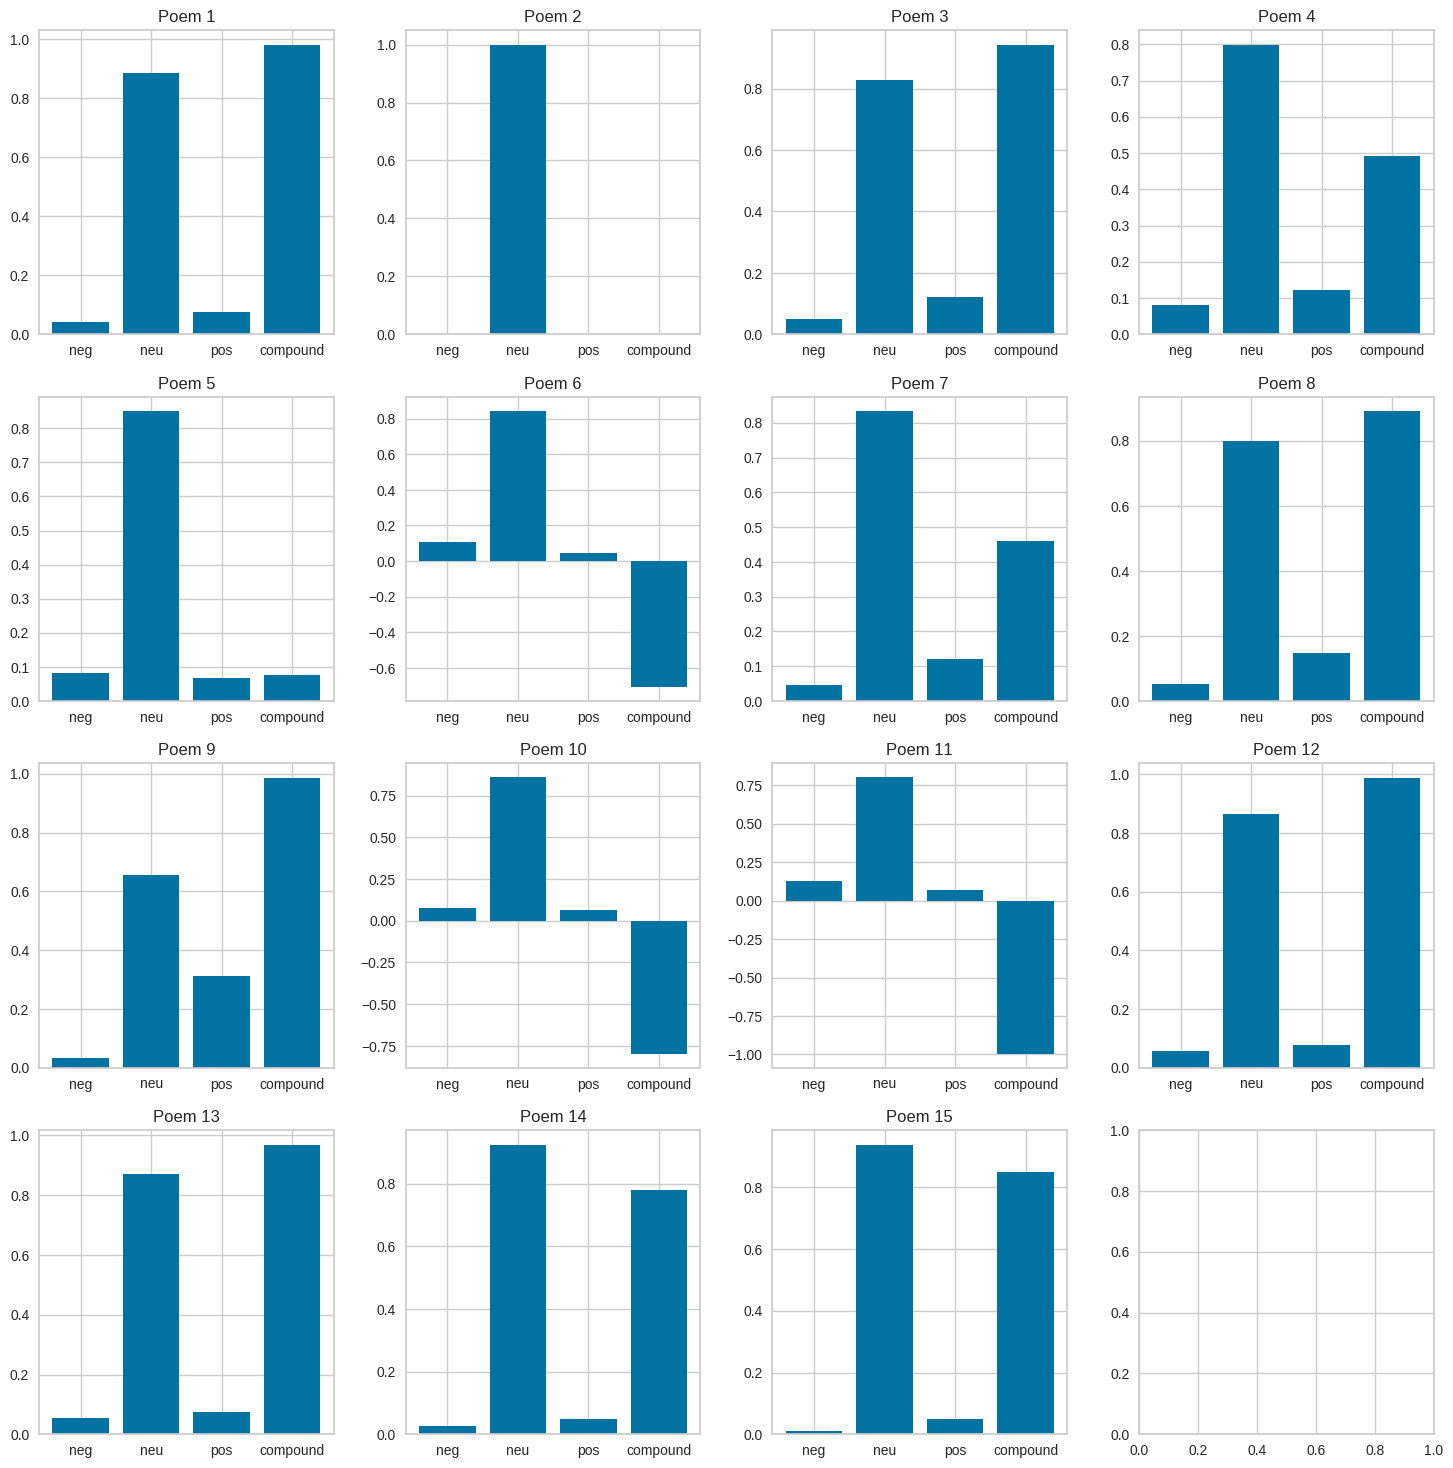

In [ ]:
plot_sentiments(pushcart_sentiment)

### Non Pushcart Poems

In [ ]:
non_pushcart_sentiment = []
i = 1
for poem in temp_non_pushcart:
    scores = sid.polarity_scores(poem)
    print(poem)
    print(scores)
    print()
    non_pushcart_sentiment.append(('Poem ' + str(i), scores))
    i += 1

 There was a daisy
Dancing on a floating island in the cosmic night
Her petals smiling at you
Looking up you see that bright light
Billions of lives floating in the sky

They’re all gone now
Burnt grass and ashes below your feet
Sparks of ember singing in the air
The watch on your wrist turned gray
That too, turned into ashes

You remember laughter
Sweet warm nectar
You feel it in your hands and
splash it on your face
That too, turned into ashes

Your hand holds a daisy
Glowing white and yellow
It whispers to you and
melts out of your hand
That too, turned into ashes

You look in the water
A little pond with your name
Swirling memories, distant sounds
Your face reflecting off the water
That too, turned into ashes
{'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'compound': 0.9607}

 If someone dies
the air is often full of sighs
and tearful sad goodbyes
if young
we mourn
the shortened span of life
since they were born
if old
we bow our heads
and wish them peaceful rest
with deep and fond respe

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


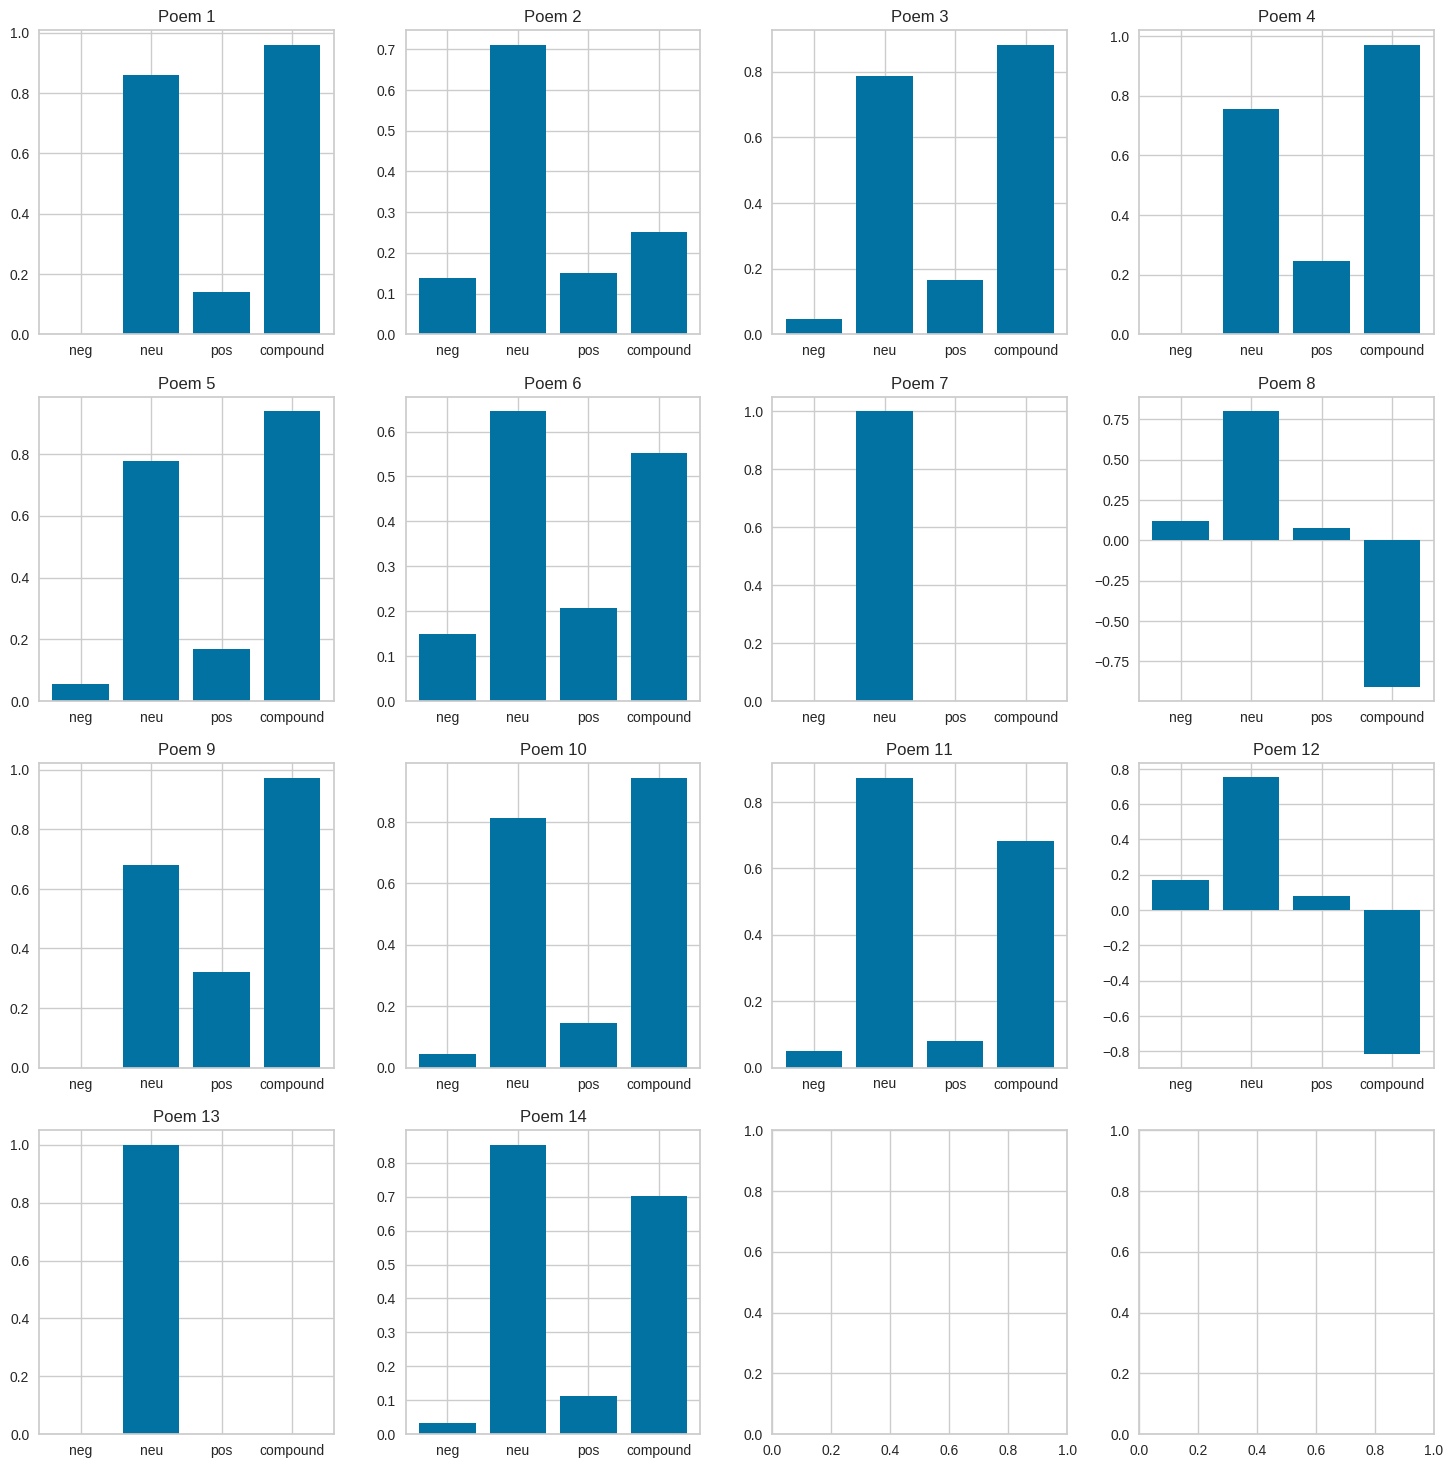

In [ ]:
plot_sentiments(non_pushcart_sentiment)

### Comparison

**By comparing and analyzing both pushcart and non-pushcart people walking poems, we can conclude that both nominated and non-nominated poems have overall positive sentiments, as evidenced by their large shares in compound scores. It's possible that the Pushcart-nominated poem uses more complex or nuanced language that the algorithm interprets as less positive, or that the sentiment analysis fails to capture the emotions conveyed in the poem accurately.**

## Knowledge Graph

In [ ]:
def create_corpus(df):
  poem_tokens = [noun + adj for noun, adj in zip(df['Nouns'], df['Adjective'])]
  tokenfreq_dict = gensim.corpora.Dictionary(poem_tokens) # make a dictionary of id to word mapping for every token in every poem
  poem_corpus = [tokenfreq_dict.doc2bow(poem) for poem in poem_tokens] # make a corpus representing the frequency of occurence (of every token in a poem) in the dictionary (created previously)

  return tokenfreq_dict, poem_corpus


In [ ]:
pushcart_word_dict, pushcart_corpus = create_corpus(pushcart_poems_df)

In [ ]:
non_pushcart_word_dict, non_pushcart_corpus = create_corpus(non_pushcart_poems_df)

### Pushcart LDA Model

In [ ]:
pushcart_ldamodel_poem = gensim.models.ldamodel.LdaModel(corpus=pushcart_corpus, num_topics=5, id2word=pushcart_word_dict, passes=15, iterations=10, random_state=5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pushcart_ldamodel_poem.show_topics(num_words=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.030*"’" + 0.016*"t" + 0.013*"s" + 0.012*"father" + 0.012*"mother" + 0.007*"Review" + 0.006*"time" + 0.005*"hands" + 0.005*"carrots" + 0.005*"face"'),
 (1,
  '0.020*"’" + 0.012*"t" + 0.011*"visitors" + 0.011*"prisoner" + 0.009*"s" + 0.009*"inmate" + 0.007*"world" + 0.007*"man" + 0.007*"visitor" + 0.007*"brother"'),
 (2,
  '0.009*"Review" + 0.008*"’" + 0.006*"color" + 0.006*"Brasil" + 0.006*"Magazine" + 0.004*"mother" + 0.004*"s" + 0.004*"school" + 0.004*"”" + 0.004*"skin"'),
 (3,
  '0.012*"’" + 0.012*"Forgive" + 0.009*"God" + 0.007*"s" + 0.007*"Simon" + 0.005*"t" + 0.005*"”" + 0.005*"“" + 0.005*"wings" + 0.005*"grandmother"'),
 (4,
  '0.016*"home" + 0.014*"’" + 0.014*"time" + 0.012*"astronaut" + 0.010*"”" + 0.009*"rice" + 0.009*"school" + 0.007*"t" + 0.007*"s" + 0.007*"mother"')]

In [ ]:
pushcart_topic_keyword_str_list = []
for i in range(5):
  top_topic_keywords = pushcart_ldamodel_poem.show_topic(i, topn=12)
  keywords = ", ".join(keyword for keyword, prob in top_topic_keywords)
  pushcart_topic_keyword_str_list.append(keywords)
  print(keywords)

’, t, s, father, mother, Review, time, hands, carrots, face, door, table
’, t, visitors, prisoner, s, inmate, world, man, visitor, brother, life, little
Review, ’, color, Brasil, Magazine, mother, s, school, ”, skin, sun, “
’, Forgive, God, s, Simon, t, ”, “, wings, grandmother, flames, wick
home, ’, time, astronaut, ”, rice, school, t, s, mother, place, sapling


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Non Pushcart LDA Model

In [ ]:
non_pushcart_ldamodel_poem= gensim.models.ldamodel.LdaModel(corpus=non_pushcart_corpus, num_topics=5, id2word=non_pushcart_word_dict, passes=15, iterations=10, random_state=5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
non_pushcart_ldamodel_poem.show_topics(num_words=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.016*"people" + 0.016*"time" + 0.011*"light" + 0.011*"My" + 0.011*"dark" + 0.011*"Someone" + 0.011*"grave" + 0.011*"life" + 0.006*"hand" + 0.006*"cold"'),
 (1,
  '0.027*"*" + 0.016*"ll" + 0.011*"such" + 0.011*"sea" + 0.011*"My" + 0.011*"sonnet" + 0.006*"sound" + 0.006*"morning" + 0.006*"full" + 0.006*"moon"'),
 (2,
  '0.024*"butterfly" + 0.020*"leaves" + 0.015*"friends" + 0.015*"African" + 0.010*"pond" + 0.010*"pathway" + 0.010*"old" + 0.010*"d" + 0.010*"stone" + 0.010*"park"'),
 (3,
  '0.031*"ashes" + 0.013*"feet" + 0.013*"air" + 0.013*"daisy" + 0.013*"face" + 0.013*"hand" + 0.013*"water" + 0.007*"light" + 0.007*"night" + 0.007*"gentle"'),
 (4,
  '0.028*"hey" + 0.011*"day" + 0.011*"exuberant" + 0.011*"Bray" + 0.011*"hay" + 0.011*"goats" + 0.011*"livestock" + 0.011*"tractor" + 0.011*"joyful" + 0.011*"dance-y"')]

In [ ]:
non_pushcart_topic_keyword_str_list = []
for i in range(4):
  top_topic_keywords = non_pushcart_ldamodel_poem.show_topic(i, topn=12)
  keywords = ", ".join(keyword for keyword, prob in top_topic_keywords)
  non_pushcart_topic_keyword_str_list.append(keywords)
  print(keywords)

people, time, light, My, dark, Someone, grave, life, hand, cold, mist, moon
*, ll, such, sea, My, sonnet, sound, morning, full, moon, hum, shivers
butterfly, leaves, friends, African, pond, pathway, old, d, stone, park, space, sky
ashes, feet, air, daisy, face, hand, water, light, night, gentle, window, sweet


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Getting Relations

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def from_text_to_kb(text,span_length=128, verbose=False):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) /
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def save_network_html(kb, filename="file.html"):
    # create network
    net = Network(notebook=True, cdn_resources='in_line',directed=True, width="700px", height="700px", bgcolor="#eeeeee")

    #nodes
    node_map = {}
    i = 0

    r = lambda: random.randint(0,255)

    for val in kb.relations:
      if val["head"] not in node_map:
        node_map[val["head"]] = i
        i+=1

      if val["tail"] not in node_map:
        node_map[val["tail"]] = i
        i+=1


    for node, i in node_map.items():
      net.add_node(i, label = node, color = '#%02X%02X%02X' % (r(),r(),r()))

    # edges
    for r in kb.relations:
        net.add_edge(node_map[r["head"]], node_map[r["tail"]])

    # save network
    net.repulsion(
        node_distance=200,
        central_gravity=0.2,
        spring_length=200,
        spring_strength=0.05,
        damping=0.09
    )

    # net.set_edge_smooth('dynamic')
    net.show(filename)
    display(HTML(filename=filename))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def save_kb(kb, filename):
    with open(filename, "wb") as f:
        pickle.dump(kb, f)

def load_kb(filename):
    res = None
    with open(filename, "rb") as f:
        res = pickle.load(f)
    return res

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plotting the graphs - Pushcart

#### Poem 1

In [ ]:
kb_pushcart= from_text_to_kb(temp_pushcart[0], verbose=True)
filename = "pushcart1"
filename_html = filename + ".html"
save_kb(kb_pushcart, filename + ".p")
save_network_html(kb_pushcart, filename=filename_html)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Token indices sequence length is longer than the specified maximum sequence length for this model (1089 > 1024). Running this sequence through the model will result in indexing errors


Input has 1089 tokens
Input has 9 spans
Span boundaries are [[0, 128], [120, 248], [240, 368], [360, 488], [480, 608], [600, 728], [720, 848], [840, 968], [960, 1088]]


#### Poem 2

In [ ]:
kb_pushcart= from_text_to_kb(temp_pushcart[1], verbose=True)
filename = "pushcart2"
filename_html = filename + ".html"
save_kb(kb_pushcart, filename + ".p")
save_network_html(kb_pushcart, filename=filename_html)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Input has 8 tokens
Input has 1 spans
Span boundaries are [[0, 128]]


#### Poem 3

In [ ]:
kb_pushcart= from_text_to_kb(temp_pushcart[2], verbose=True)
filename = "pushcart3"
filename_html = filename + ".html"
save_kb(kb_pushcart, filename + ".p")
save_network_html(kb_pushcart, filename=filename_html)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Input has 317 tokens
Input has 3 spans
Span boundaries are [[0, 128], [94, 222], [188, 316]]


#### Poem 4

In [ ]:
kb_pushcart= from_text_to_kb(temp_pushcart[3], verbose=True)
filename = "pushcart4"
filename_html = filename + ".html"
save_kb(kb_pushcart, filename + ".p")
save_network_html(kb_pushcart, filename=filename_html)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Input has 191 tokens
Input has 2 spans
Span boundaries are [[0, 128], [63, 191]]


### Plotting the graphs - Non Pushcart

#### Poem 1

In [ ]:
kb_pushcart= from_text_to_kb(temp_non_pushcart[0], verbose=True)
filename = "non_pushcart1"
filename_html = filename + ".html"
save_kb(kb_pushcart, filename + ".p")
save_network_html(kb_pushcart, filename=filename_html)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Input has 187 tokens
Input has 2 spans
Span boundaries are [[0, 128], [59, 187]]


#### Poem 2

In [ ]:
kb_pushcart= from_text_to_kb(temp_non_pushcart[1], verbose=True)
filename = "non_pushcart2"
filename_html = filename + ".html"
save_kb(kb_pushcart, filename + ".p")
save_network_html(kb_pushcart, filename=filename_html)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Input has 91 tokens
Input has 1 spans
Span boundaries are [[0, 128]]


#### Poem 3

In [ ]:
kb_pushcart= from_text_to_kb(temp_non_pushcart[2], verbose=True)
filename = "non_pushcart3"
filename_html = filename + ".html"
save_kb(kb_pushcart, filename + ".p")
save_network_html(kb_pushcart, filename=filename_html)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Input has 137 tokens
Input has 2 spans
Span boundaries are [[0, 128], [9, 137]]


#### Poem 4

In [ ]:
kb_pushcart= from_text_to_kb(temp_non_pushcart[3], verbose=True)
filename = "non_pushcart4"
filename_html = filename + ".html"
save_kb(kb_pushcart, filename + ".p")
save_network_html(kb_pushcart, filename=filename_html)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Input has 76 tokens
Input has 1 spans
Span boundaries are [[0, 128]]
